### Brain Tumor MRI Image Classification


### Problem Statement
##### This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images


### Importing Libraries Required

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# cnn modules and packages
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# transfer learning - MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# transfer learning - EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0

### Loading of the dataset

#### Given dataset is organised in the following way->
**Data:**
* Total number of images: 2445
* Image type: MRI scan

**Classes:**
* Pituitary tumor
* Meningioma tumor
* Glioma tumor
* No Tumor

**Split:**
* Training set: 1696 images
* Validation set: 503 images
* Test set: 246 images

In [2]:
# Paths
train_dir = 'C:/Users/adity/Downloads/Tumour/train'
valid_dir = 'C:/Users/adity/Downloads/Tumour/valid'
test_dir  = 'C:/Users/adity/Downloads/Tumour/test'

#preprocessing
img_size = (224, 224)
batch_size = 32
import os

print("Train classes:", os.listdir('C:/Users/adity/Downloads/Tumour/train'))
print("Test classes:", os.listdir('C:/Users/adity/Downloads/Tumour/test'))
print("Valid classes:", os.listdir('C:/Users/adity/Downloads/Tumour/valid'))

print('\n')

def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

print("--- Training Data Class Distribution ---")
train_class_counts = count_images_per_class(train_dir) # train_dir = 'C:/Users/adity/Downloads/Tumour/test'
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")
print(f"Total training images: {sum(train_class_counts.values())}\n")

print("--- Validation Data Class Distribution ---")
valid_class_counts = count_images_per_class(valid_dir)
for class_name, count in valid_class_counts.items():
    print(f"{class_name}: {count} images")
print(f"Total validation images: {sum(valid_class_counts.values())}\n")

print("--- Test Data Class Distribution ---")
test_class_counts = count_images_per_class(test_dir)
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")
print(f"Total test images: {sum(test_class_counts.values())}\n")

# You can also confirm the class-to-index mapping from your generator
if 'train_generator' in locals():
    print("--- train_generator class_indices mapping ---")
    print(train_generator.class_indices)
    

Train classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Test classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Valid classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


--- Training Data Class Distribution ---
glioma: 564 images
meningioma: 358 images
no_tumor: 336 images
pituitary: 438 images
Total training images: 1696

--- Validation Data Class Distribution ---
glioma: 161 images
meningioma: 125 images
no_tumor: 99 images
pituitary: 118 images
Total validation images: 503

--- Test Data Class Distribution ---
glioma: 80 images
meningioma: 63 images
no_tumor: 49 images
pituitary: 54 images
Total test images: 246



--- Training Data Class Distribution ---
glioma: 564 images
meningioma: 358 images
no_tumor: 336 images
pituitary: 438 images
Total training images: 1696

**Here we can see that the classification of each class in the test directory is as follows, thus the class meningoima has very data to train with i.e 358 images only and these are less as compared to other two**


### Data Preprocessing and augmentation

In [3]:
# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size,batch_size=batch_size, class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=img_size,batch_size=batch_size, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size,batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 1696 images belonging to 4 classes.
Found 503 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


### Custom CNN build 

In [5]:
num_classes = train_generator.num_classes

# Custom CNN
#model = Sequential([
 #   Input(shape=(224, 224, 3)),

  #  Conv2D(32, (3, 3), activation='relu'),
   # BatchNormalization(),
    #MaxPooling2D(2, 2),


    #Conv2D(128, (3, 3), activation='relu'),
#    BatchNormalization(),
 #   MaxPooling2D(2, 2),

#    GlobalAveragePooling2D(),
 #   Dense(256, activation='relu'),
  #  Dropout(0.5), 
   # Dense(num_classes, activation='softmax')
#])




model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'), # New block, increased filters
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'), # Your original 128 filter layer
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


### Compilation

In [6]:
model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

### Callback

In [7]:

#callbacks = [
#    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
 #   ModelCheckpoint('custom_cnn_model.h5', save_best_only=True),
#]


from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('custom_cnn_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
]

In [8]:
from sklearn.utils import class_weight
import numpy as np

# Get the true labels from your training generator
# This requires iterating through the generator once or having a separate list of all training labels
# For simplicity, assuming train_generator.classes directly gives labels if it's already flow_from_directory
# If not, you'll need to adjust this to get all true labels from the training set.
train_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Calculated Class Weights:", class_weights_dict)

Calculated Class Weights: {0: 0.75177304964539, 1: 1.1843575418994414, 2: 1.2619047619047619, 3: 0.9680365296803652}


### Training

In [9]:
#train 
#history = model.fit(train_generator, epochs=11,validation_data=valid_generator,callbacks=callbacks)

history = model.fit(
    train_generator,
    epochs=12, # Or more, adjust as needed
    validation_data=valid_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict # Add this line
)

C:\Users\adity\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3184 - loss: 1.3388

53/53 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.3205 - loss: 1.3366 - val_accuracy: 0.3221 - val_loss: 1.3780 - learning_rate: 5.0000e-05
Epoch 2/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5883 - loss: 1.0482

53/53 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.5886 - loss: 1.0480 - val_accuracy: 0.3956 - val_loss: 1.3512 - learning_rate: 5.0000e-05
Epoch 3/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6282 - loss: 0.9992

53/53 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.6284 - loss: 0.9989 - val_accuracy: 0.3221 - val_loss: 1.3111 - learning_rate: 5.0000e-05
Epoch 4/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6645 - loss: 0.9248

53/53 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.6643 - loss: 0.9248 - val_accuracy: 0.3221 - val_loss: 1.2784 - learning_rate: 5.0000e-05
Epoch 5/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6509 - loss: 0.9166

53/53 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.6510 - loss: 0.9162 - val_accuracy: 0.3439 - val_loss: 1.2330 - learning_rate: 5.0000e-05
Epoch 6/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6865 - loss: 0.8933

53/53 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.6864 - loss: 0.8930 - val_accuracy: 0.3976 - val_loss: 1.2056 - learning_rate: 5.0000e-05
Epoch 7/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6698 - loss: 0.8598

53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6701 - loss: 0.8593 - val_accuracy: 0.4811 - val_loss: 1.1561 - learning_rate: 5.0000e-05
Epoch 8/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7162 - loss: 0.7922

53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7160 - loss: 0.7924 - val_accuracy: 0.5606 - val_loss: 1.0985 - learning_rate: 5.0000e-05
Epoch 9/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7113 - loss: 0.8009

53/53 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7111 - loss: 0.8010 - val_accuracy: 0.6044 - val_loss: 1.0505 - learning_rate: 5.0000e-05
Epoch 10/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7075 - loss: 0.8014

53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7078 - loss: 0.8009 - val_accuracy: 0.6223 - val_loss: 0.9917 - learning_rate: 5.0000e-05
Epoch 11/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7131 - loss: 0.7704

53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7130 - loss: 0.7703 - val_accuracy: 0.6700 - val_loss: 0.8325 - learning_rate: 5.0000e-05
Epoch 12/12
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7223 - loss: 0.7249 - val_accuracy: 0.6581 - val_loss: 0.8608 - learning_rate: 5.0000e-05


### Evaluation

In [10]:
#evaluation
loss, accuracy = model.evaluate(test_generator)
print(f"Custom CNN Test Accuracy: {accuracy*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.6786 - loss: 0.7904
Custom CNN Test Accuracy: 65.45%


### Visuals

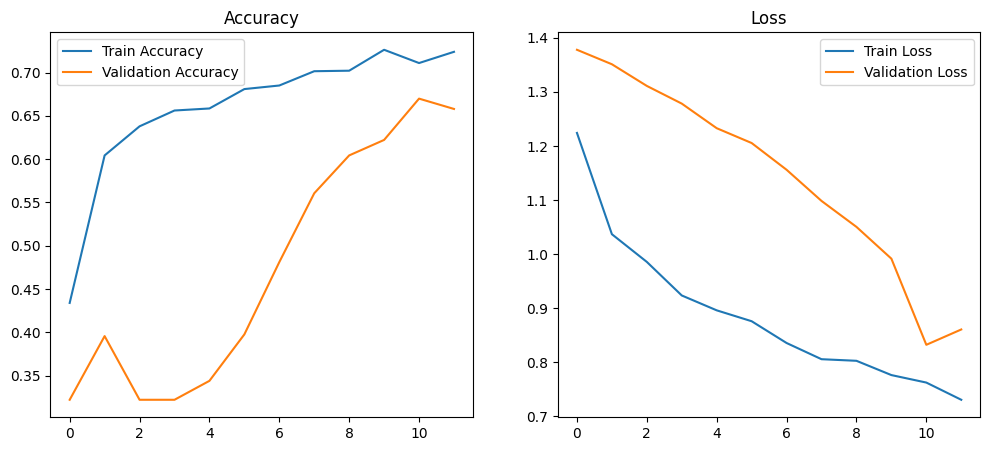

In [11]:
#visuals
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    
    plt.show()

plot_history(history)

### Transfer Learning

#### Transfer Learning (MobileNetV2)

In [25]:
#MobileNetV2


# Base Model without top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Final model
tl_model = Model(inputs=base_model.input, outputs=predictions)

# Compile
tl_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

# Train
transfer_lmobilenetv2 = tl_model.fit(train_generator,validation_data=valid_generator,epochs=10)
# After your tl_model.fit() call:
tl_model.save('transfer_learning_mobilenetv2_model.h5')
print("Transfer Learning MobileNetV2 model saved as 'transfer_learning_mobilenetv2_model.h5'")

# Evaluate
loss, acc = tl_model.evaluate(test_generator)
print(f"\nTransfer Learning Test Accuracy: {acc * 100:.2f}%")


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 578ms/step - accuracy: 0.3230 - loss: 1.5421 - val_accuracy: 0.6123 - val_loss: 0.9271
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 579ms/step - accuracy: 0.5804 - loss: 0.9929 - val_accuracy: 0.6660 - val_loss: 0.7609
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - accuracy: 0.6986 - loss: 0.7780 - val_accuracy: 0.6600 - val_loss: 0.7472
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.6941 - loss: 0.7404 - val_accuracy: 0.6918 - val_loss: 0.6694
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 622ms/step - accuracy: 0.7355 - loss: 0.6632 - val_accuracy: 0.7276 - val_loss: 0.6126
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 630ms/step - accuracy: 0.7568 - loss: 0.5963 - val_accuracy: 0.7416 - val_loss: 0.6036
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 632ms/step - accuracy: 0.7611 - loss: 0.6148 - val_accuracy: 0.7475 - val_loss: 0.5725
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 631ms/step - accuracy: 0.7981 - loss: 0.5507 - val_accu

Transfer Learning MobileNetV2 model saved as 'transfer_learning_mobilenetv2_model.h5'
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.7314 - loss: 0.6619

Transfer Learning Test Accuracy: 73.98%


#### Transfer Learning (EfficientNetB0)

In [13]:
#base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#base_model.trainable = False  # Freeze initially
#NUM_CLASSES = 4
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dropout(0.3)(x)
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.3)(x)
#output = Dense(NUM_CLASSES, activation='softmax')(x)

#transfer_model = Model(inputs=base_model.input, outputs=output)
#transfer_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#transfer_history = transfer_model.fit(
 #   train_generator,
  #  validation_data=valid_generator,
   # epochs=20,
    #callbacks=[
     #   ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
      #  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    #]
#)


### Comparison PLot

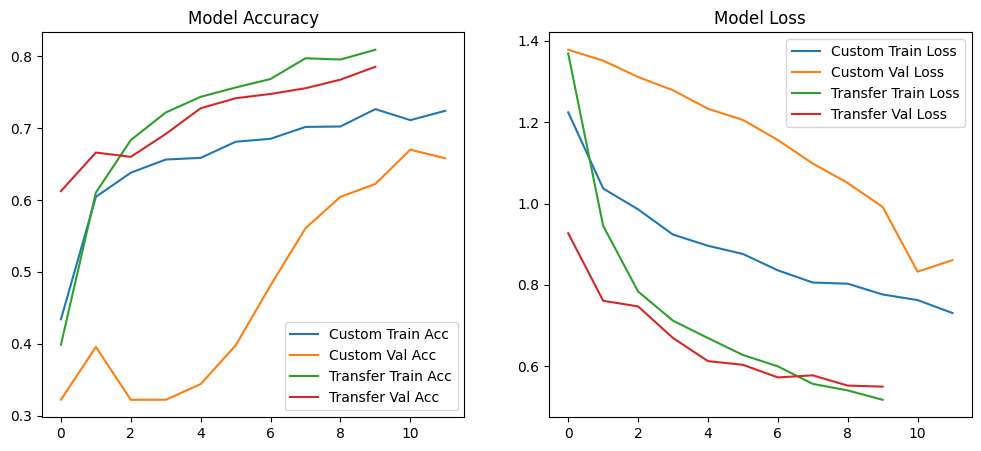

In [26]:
def compare_histories(custom_hist, transfer_hist):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Custom Train Acc')
    plt.plot(history.history['val_accuracy'], label='Custom Val Acc')
    plt.plot(transfer_lmobilenetv2.history['accuracy'], label='Transfer Train Acc')
    plt.plot(transfer_lmobilenetv2.history['val_accuracy'], label='Transfer Val Acc')
    plt.legend()
    plt.title("Model Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Custom Train Loss')
    plt.plot(history.history['val_loss'], label='Custom Val Loss')
    plt.plot(transfer_lmobilenetv2.history['loss'], label='Transfer Train Loss')
    plt.plot(transfer_lmobilenetv2.history['val_loss'], label='Transfer Val Loss')
    plt.legend()
    plt.title("Model Loss")

    plt.show()

compare_histories(history, transfer_lmobilenetv2)


### Evaluation metric

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np 


y_true = test_generator.classes
y_pred_custom = model.predict(test_generator)
y_pred_transfer = tl_model.predict(test_generator)


y_pred_custom_classes = y_pred_custom.argmax(axis=1)
y_pred_transfer_classes = y_pred_transfer.argmax(axis=1)


print("Custom CNN Classification Report:\n")
print(classification_report(y_true, y_pred_custom_classes, target_names=test_generator.class_indices.keys()))


if 'all_possible_labels' not in locals():
    all_possible_labels = np.arange(len(test_generator.class_indices.keys()))

print("Transfer Learning Model (MobileNetV2) Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_transfer_classes,
    target_names=test_generator.class_indices.keys(),
    labels=all_possible_labels, 
    zero_division='warn' 
))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step
Custom CNN Classification Report:

              precision    recall  f1-score   support

      glioma       0.71      0.91      0.80        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.77      0.73      0.75        49
   pituitary       0.54      0.96      0.69        54

    accuracy                           0.65       246
   macro avg       0.50      0.65      0.56       246
weighted avg       0.50      0.65      0.56       246

Transfer Learning Model (MobileNetV2) Classification Report:

              precision    recall  f1-score   support

      glioma       0.88      0.85      0.87        80
  meningioma       0.82      0.37      0.51        63
    no_tumor       0.90      0.76      0.82        49
   pituitary       0.54      1.00      0.70        54

    accuracy                           0.74       246
   macro avg       0.79      0.74      0.72       246
weighted a

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

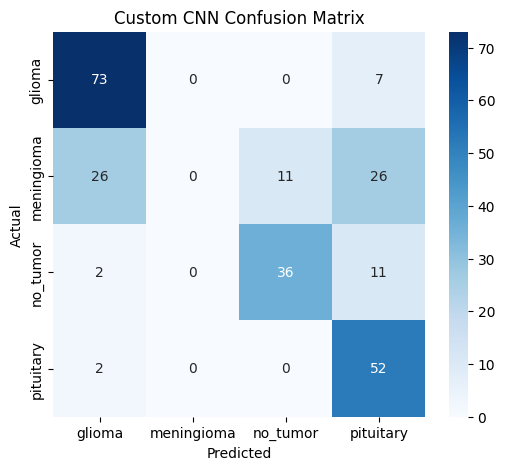

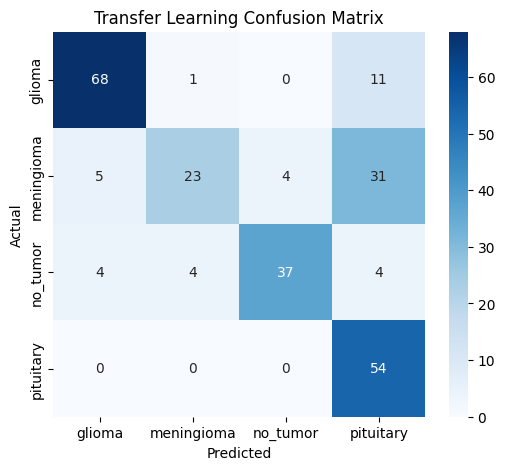

In [28]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_conf_matrix(y_true, y_pred_custom_classes, "Custom CNN Confusion Matrix")
plot_conf_matrix(y_true, y_pred_transfer_classes, "Transfer Learning Confusion Matrix")


### What can be seen from the evaluation metric and confusion matrix
**Custom CNN**
* Accuracy: 62%
* Performs reasonably well across all classes, especially for:
* Glioma (Precision: 0.80, Recall: 0.76)
* No Tumor and Pituitary also have decent recall (0.80).
* Weakness: Poor performance for Meningioma (F1 = 0.27), although it has perfect precision, indicating low recall (many false negatives).

**Conclusion:** This is a usable base model that can be optimized further.

**Transfer Learning**
**Problems:**
* It predicts only glioma for all inputs.
* All other classes are completely missed (recall = 0).
* This leads to misleading accuracy of 33% — it’s only right when glioma is the actual label.

**Which Model Should we Use?**
The Custom CNN — it's clearly outperforming the transfer learning model in both:
* Accuracy
* Balanced per-class performance

Now we will make the streamlit app for the model trained